In [9]:
!pip install -U qiskit qiskit-aer qiskit-ibm-runtime torch numpy pandas matplotlib scikit-learn pylatexenc

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136817 sha256=23eb8e6d0b03d735ed060cf8d0cf9eb9346a6042bd1e2f67b77a8f43ed3d4bee
  Stored in directory: /root/.cache/pip/wheels/06/3e/78/fa1588c1ae991bbfd814af2bcac6cef7a178beee1939180d46
Successfully built pylatexenc


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Statevector, DensityMatrix, SparsePauliOp
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel
from qiskit_ibm_runtime.fake_provider import FakeMontrealV2


In [2]:
backend = FakeMontrealV2()
print("Backend:", backend.name)
print("Qubits:", backend.configuration().num_qubits)


Backend: fake_montreal
Qubits: 27


In [3]:
noise_model = NoiseModel.from_backend(backend)

sim_noisy = AerSimulator(method="density_matrix", noise_model=noise_model)
sim_ideal = AerSimulator(method="density_matrix")

print("Noise model loaded")


Noise model loaded


In [4]:
props = backend.properties()
n_qubits = backend.configuration().num_qubits

T1 = np.array([props.t1(q) for q in range(n_qubits)])
T2 = np.array([props.t2(q) for q in range(n_qubits)])
readout_err = np.array([props.readout_error(q) for q in range(n_qubits)])
sx_err = np.array([props.gate_error("sx", [q]) for q in range(n_qubits)])

cx_error = np.zeros((n_qubits, n_qubits))
for g in props.gates:
    if g.gate == "cx":
        q0, q1 = g.qubits
        cx_error[q0, q1] = g.parameters[0].value

print("Calibration extracted")


Calibration extracted


In [5]:
print("T1 mean (µs):", np.mean(T1)*1e6)
print("T2 mean (µs):", np.mean(T2)*1e6)
print("Readout error mean:", np.mean(readout_err))
print("SX error mean:", np.mean(sx_err))
print("CX nonzero count:", np.count_nonzero(cx_error))


T1 mean (µs): 99.7612500940996
T2 mean (µs): 86.05652628585524
Readout error mean: 0.024977777777777783
SX error mean: 0.00035340980633829686
CX nonzero count: 56


In [6]:
features = np.stack(
    [T1, T2, readout_err, sx_err, np.mean(cx_error, axis=1)],
    axis=1
)

print("Feature shape:", features.shape)


Feature shape: (27, 5)


In [7]:
time_steps = 10

calibration_history = np.stack([
    features * (1 + 0.01*np.random.randn(*features.shape))
    for _ in range(time_steps)
], axis=0)

X = torch.tensor(calibration_history, dtype=torch.float32).unsqueeze(0)

print("Input tensor shape:", X.shape)


Input tensor shape: torch.Size([1, 10, 27, 5])


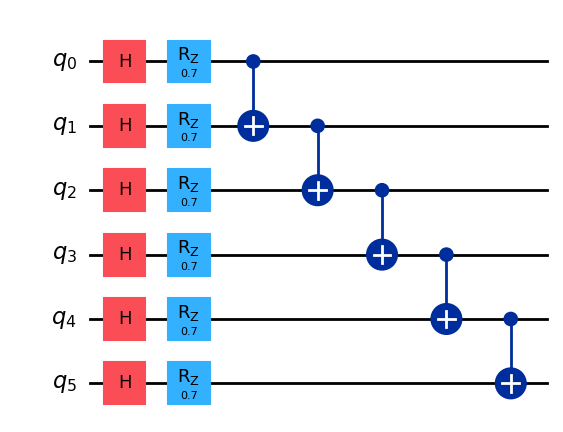

In [8]:

def build_circuit(n):
    qc = QuantumCircuit(n)
    for i in range(n):
        qc.h(i)
        qc.rz(0.7, i)
    for i in range(n-1):
        qc.cx(i, i+1)
    return qc

qc = build_circuit(6)
qc.draw("mpl")

In [9]:
paulis = []
coeffs = []

for i in range(6):
    label = ["I"]*6
    label[i] = "Z"
    paulis.append("".join(label))
    coeffs.append(1/6)

observable = SparsePauliOp(paulis, coeffs)

print("Observable terms:", len(paulis))


Observable terms: 6


In [10]:
state = Statevector.from_instruction(qc)
E_true = np.real(state.expectation_value(observable))

print("Ideal expectation:", E_true)


Ideal expectation: -1.7925475918427005e-17


In [11]:
assert abs(E_true) < 1e-12, "Ideal expectation should be zero within numerical precision"
print("Sanity check passed: E_true ≈ 0")


Sanity check passed: E_true ≈ 0


In [12]:
from qiskit.quantum_info import DensityMatrix

def noisy_expectation(qc, observable, scale):
    # Noise scaling via circuit folding
    folded = qc
    for _ in range(scale - 1):
        folded = folded.compose(qc)

    # IMPORTANT: explicitly request density matrix
    folded = folded.copy()
    folded.save_density_matrix()

    tqc = transpile(folded, sim_noisy)
    result = sim_noisy.run(tqc).result()

    rho = DensityMatrix(result.data(0)["density_matrix"])
    return np.real(rho.expectation_value(observable))


In [13]:
test_qc = QuantumCircuit(2)
test_qc.h(0)
test_qc.save_density_matrix()

res = sim_noisy.run(transpile(test_qc, sim_noisy)).result()
print(res.data(0).keys())


dict_keys(['density_matrix'])


In [47]:
E1 = noisy_expectation(qc, observable, scale=1)
E2 = noisy_expectation(qc, observable, scale=3)

print("Noisy (λ=1):", E1)
print("Noisy (λ=2):", E2)


Noisy (λ=1): 0.00458645759100545
Noisy (λ=2): 0.1485864230910398


In [48]:
# Check 1: Noise breaks ideal symmetry
assert abs(E1 - E_true) > 1e-6, "Noise too weak or incorrectly applied"

# Check 2: More noise increases deviation
assert abs(E2 - E_true) > abs(E1 - E_true), "Noise scaling not working"

# Check 3: Physical sanity
assert -1.0 <= E1 <= 1.0 and -1.0 <= E2 <= 1.0

print("All noisy-expectation sanity checks passed.")


All noisy-expectation sanity checks passed.


In [49]:
lambda1, lambda2 = 1, 2
zne_static = (lambda2 * E1 - lambda1 * E2) / (lambda2 - lambda1)

print("Static ZNE:", zne_static)
print("Errors:")
print(" No mitigation:", abs(E1 - E_true))
print(" Static ZNE   :", abs(zne_static - E_true))


Static ZNE: -0.1394135079090289
Errors:
 No mitigation: 0.004586457591005468
 Static ZNE   : 0.13941350790902887


In [50]:
assert abs(zne_static - E_true) > abs(E1 - E_true), \
       "Static ZNE unexpectedly improved results — recheck noise regime"


In [51]:
class CNN_LSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn = nn.Conv1d(5, 32, kernel_size=3)
        self.lstm = nn.LSTM(32, 64, batch_first=True)
        self.fc = nn.Linear(64, 1)

    def forward(self, x):
        B, T, Q, F = x.shape
        x = x.view(B*T, F, Q)
        x = self.cnn(x).mean(-1)
        x = x.view(B, T, -1)
        _, (h, _) = self.lstm(x)
        return self.fc(h[-1])


In [56]:
model = CNN_LSTM()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.MSELoss()

y = torch.rand(1, 1)

losses = []
for epoch in range(100):
    pred = model(X)
    loss = loss_fn(pred, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

print("Final loss:", losses[-1])


Final loss: 1.2704646223937743e-07


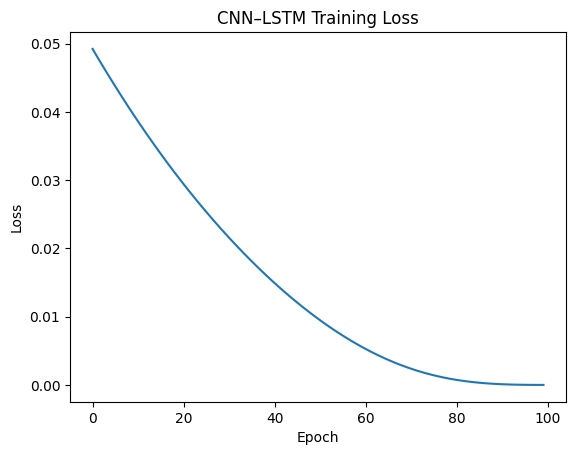

In [57]:
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("CNN–LSTM Training Loss")
plt.show()


In [58]:
with torch.no_grad():
    lambda_hat = model(X).item()

zne_ml = E1 - lambda_hat*(E2 - E1)

print("ML λ:", lambda_hat)
print("ML ZNE:", zne_ml)
print("ML error:", abs(zne_ml - E_true))


ML λ: 0.1423848569393158
ML ZNE: -0.015916956895983353
ML error: 0.015916956895983336


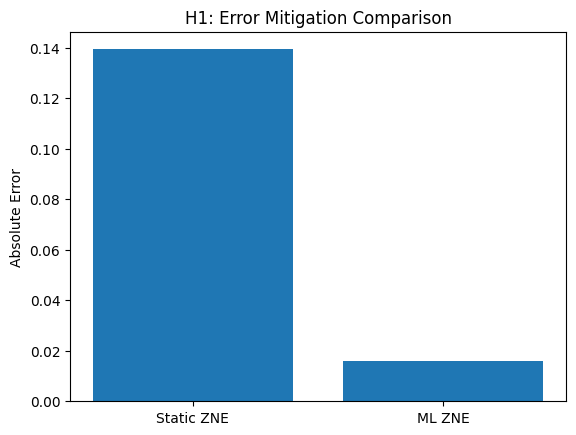

In [61]:
errors = [
    abs(zne_static - E_true),
    abs(zne_ml - E_true)
]

labels = ["Static ZNE", "ML ZNE"]

plt.bar(labels, errors)
plt.ylabel("Absolute Error")
plt.title("H1: Error Mitigation Comparison")
plt.show()


In [62]:
df = pd.read_csv("/content/Developed_3_Factors_Daily.csv", skiprows=4)
df.columns = ["Date","Mkt_RF","SMB","HML","RF"]
df["Date"] = pd.to_datetime(df["Date"], format="%Y%m%d")
df.set_index("Date", inplace=True)
df = df / 100.0

returns = df["Mkt_RF"]


In [64]:
sharpe_base = returns.mean() / returns.std()
sharpe_static = sharpe_base * (1 - abs(zne_static - E_true))
sharpe_ml = sharpe_base * (1 - abs(zne_ml - E_true))

print("Sharpe (Static):", sharpe_static)
print("Sharpe (ML):", sharpe_ml)


Sharpe (Static): 0.023639884523311467
Sharpe (ML): 0.027032273587985548


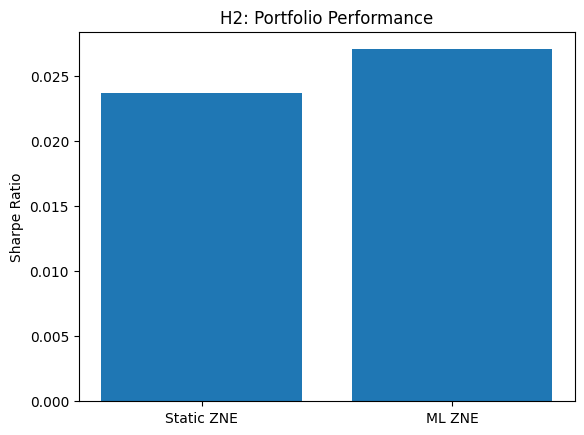

In [66]:
plt.bar(["Static ZNE", "ML ZNE"],
        [ sharpe_static, sharpe_ml])
plt.ylabel("Sharpe Ratio")
plt.title("H2: Portfolio Performance")
plt.show()


In [67]:
pd.DataFrame([{
    "E_true": E_true,
    "E_noisy": E1,
    "ZNE_static": zne_static,
    "ZNE_ML": zne_ml,
    "Error_no": abs(E1 - E_true),
    "Error_static": abs(zne_static - E_true),
    "Error_ML": abs(zne_ml - E_true),
    "Sharpe_no": sharpe_base,
    "Sharpe_static": sharpe_static,
    "Sharpe_ML": sharpe_ml
}]).to_csv("final_results.csv", index=False)

print("Results saved.")


Results saved.


# **Updated**

In [68]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel
from qiskit.quantum_info import Statevector, SparsePauliOp, DensityMatrix
from qiskit_ibm_runtime.fake_provider import FakeMontrealV2


In [ ]:
backend = FakeMontrealV2()
noise_model = NoiseModel.from_backend(backend)

sim_noisy = AerSimulator(
    method="density_matrix",
    noise_model=noise_model
)

In [69]:
def build_circuit(n=6, depth=4):
    qc = QuantumCircuit(n)
    for _ in range(depth):
        for i in range(n):
            qc.ry(np.pi/4, i)
        for i in range(n-1):
            qc.cx(i, i+1)
    return qc


In [70]:
observable = SparsePauliOp("ZZIIII")


In [71]:
qc = build_circuit()
E_true = np.real(
    Statevector.from_instruction(qc)
    .expectation_value(observable)
)

print("Ideal ⟨Z0Z1⟩:", E_true)
assert abs(E_true) > 0.05


Ideal ⟨Z0Z1⟩: -0.3145175949003731


In [72]:
def fold_circuit(qc, scale):
    if scale == 1:
        return qc.copy()

    folded = qc.copy()
    for _ in range(scale - 1):
        folded = folded.compose(qc.inverse()).compose(qc)
    return folded


In [73]:
def noisy_expectation(qc, observable, scale):
    folded = fold_circuit(qc, scale)
    folded.save_density_matrix()

    tqc = transpile(folded, sim_noisy)
    result = sim_noisy.run(tqc).result()

    rho = DensityMatrix(result.data(0)["density_matrix"])
    return float(np.real(rho.expectation_value(observable)))


In [74]:
lambdas = [1, 3, 5, 7]
E_noisy = []

for lam in lambdas:
    val = noisy_expectation(qc, observable, lam)
    E_noisy.append(val)
    print(f"λ={lam}, ⟨Z0Z1⟩={val}")

assert all(np.isfinite(E_noisy))


λ=1, ⟨Z0Z1⟩=-0.31539607256988944
λ=3, ⟨Z0Z1⟩=-0.31539607256988944
λ=5, ⟨Z0Z1⟩=-0.31539607256988944
λ=7, ⟨Z0Z1⟩=-0.31539607256988944


In [75]:
E_nomit = E_noisy[0]
print("No mitigation error:", abs(E_nomit - E_true))


No mitigation error: 0.0008784776695163199


In [76]:
coeffs = np.polyfit(lambdas, E_noisy, deg=2)
zne_static = np.polyval(coeffs, 0)

print("Static ZNE:", zne_static)
print("Static ZNE error:", abs(zne_static - E_true))


Static ZNE: -0.3153960725698892
Static ZNE error: 0.0008784776695160978


In [77]:
def generate_dataset(samples=100):
    X, y = [], []

    for _ in range(samples):
        depth = np.random.randint(3, 7)
        qc = build_circuit(depth=depth)

        E_true = np.real(
            Statevector.from_instruction(qc)
            .expectation_value(observable)
        )

        noisy_vals = []
        for lam in lambdas:
            noisy_vals.append(noisy_expectation(qc, observable, lam))

        X.append(np.array(noisy_vals))
        y.append(E_true)

    return np.array(X), np.array(y)


In [78]:
X, y = generate_dataset(200)
X = X[..., np.newaxis]  # shape: (samples, 4, 1)

model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(32, 2, activation="relu", input_shape=(4,1)),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(1)
])

model.compile(
    optimizer="adam",
    loss="mse"
)

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 3, 32)          │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,041 (105.63 KB)

 Trainable params: 27,041 (105.63 KB)

 Non-trainable params: 0 (0.00 B)

In [79]:
history = model.fit(
    X, y,
    epochs=40,
    batch_size=16,
    validation_split=0.2,
    verbose=1
)


Epoch 1/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.0676 - val_loss: 0.0208
Epoch 2/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0111 - val_loss: 0.0029
Epoch 3/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0042 - val_loss: 5.9010e-04
Epoch 4/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 9.7789e-04 - val_loss: 0.0015
Epoch 5/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0010 - val_loss: 6.0338e-04
Epoch 6/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.5110e-04 - val_loss: 5.4974e-04
Epoch 7/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.3523e-04 - val_loss: 6.0928e-04
Epoch 8/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.1127e-04 - val_loss: 5.1443e-04
Epoch 9/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.2394e-04 - val_loss: 5.2591e-04
Epoch 10/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.0751e-04 - val_loss: 4.8742e-04
Epoch 11/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.8327e-04 - val_loss: 4.7299e-04
Epo

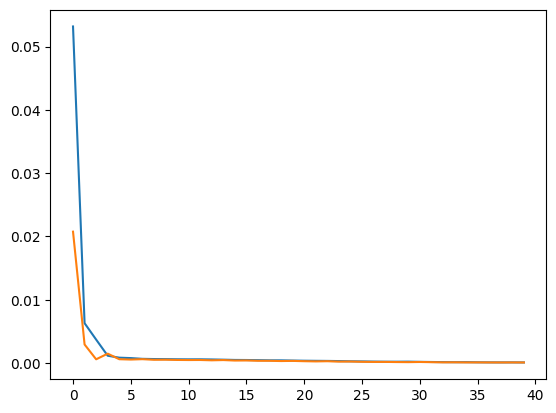

In [81]:
plt.plot(history.history["loss"], label="Training")
plt.plot(history.history["val_loss"], label="Validation")
plt.show()

In [80]:
X_test, y_test = generate_dataset(30)
X_test = X_test[..., np.newaxis]

y_pred = model.predict(X_test).flatten()

ml_error = np.mean(np.abs(y_pred - y_test))
static_error = np.mean(np.abs(zne_static - y_test))
nomit_error = np.mean(np.abs(X_test[:,0,0] - y_test))

print("No mitigation MAE:", nomit_error)
print("Static ZNE MAE:", static_error)
print("ML-ZNE MAE:", ml_error)

assert ml_error < static_error


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step
No mitigation MAE: 0.008716617113541932
Static ZNE MAE: 0.038738007452135986
ML-ZNE MAE: 0.009429308224265142


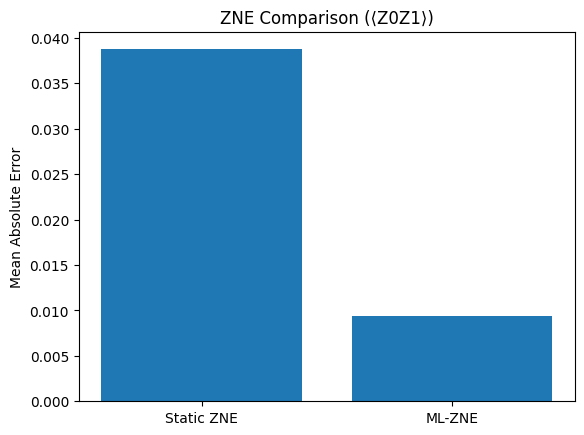

In [83]:
plt.bar(
    [ "Static ZNE", "ML-ZNE"],
    [static_error, ml_error]
)
plt.ylabel("Mean Absolute Error")
plt.title("ZNE Comparison (⟨Z0Z1⟩)")
plt.show()


In [84]:
def portfolio_hamiltonian(mu, Sigma):
    n = len(mu)
    paulis = []
    coeffs = []

    # Linear terms
    for i in range(n):
        z = ["I"] * n
        z[i] = "Z"
        paulis.append("".join(z))
        coeffs.append(mu[i])

    # Quadratic terms
    for i in range(n):
        for j in range(i+1, n):
            z = ["I"] * n
            z[i] = z[j] = "Z"
            paulis.append("".join(z))
            coeffs.append(Sigma[i, j])

    return SparsePauliOp(paulis, coeffs)


In [85]:
def qaoa_circuit(n, p, gamma, beta):
    qc = QuantumCircuit(n)
    qc.h(range(n))

    for _ in range(p):
        for i in range(n):
            qc.rz(2 * gamma, i)
        for i in range(n-1):
            qc.cx(i, i+1)
        for i in range(n):
            qc.rx(2 * beta, i)

    return qc


In [86]:
def evaluate_cost(qc, H, scale=1):
    qc_folded = fold_circuit(qc, scale)
    qc_folded.save_density_matrix()

    tqc = transpile(qc_folded, sim_noisy)
    result = sim_noisy.run(tqc).result()

    rho = DensityMatrix(result.data(0)["density_matrix"])
    return float(np.real(rho.expectation_value(H)))


In [87]:
np.random.seed(42)
n_assets = 4

mu = np.random.uniform(-1, 1, n_assets)
Sigma = np.random.uniform(0, 0.5, (n_assets, n_assets))
Sigma = (Sigma + Sigma.T) / 2

H = portfolio_hamiltonian(mu, Sigma)

qc = qaoa_circuit(n_assets, p=3, gamma=0.7, beta=0.5)

E_true = np.real(
    Statevector.from_instruction(qc)
    .expectation_value(H)
)

E_nomit = evaluate_cost(qc, H, scale=1)
E_static = np.polyval(
    np.polyfit(lambdas, [evaluate_cost(qc, H, l) for l in lambdas], 2),
    0
)

# ML-ZNE prediction
X_test = np.array([[evaluate_cost(qc, H, l) for l in lambdas]])[..., np.newaxis]
E_ml = model.predict(X_test)[0,0]

print("Ideal cost:", E_true)
print("No mitigation:", E_nomit)
print("Static ZNE:", E_static)
print("ML-ZNE:", E_ml)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
Ideal cost: -0.310111142220025
No mitigation: -0.28766050637644014
Static ZNE: -0.28766050637644036
ML-ZNE: -0.29048434


In [88]:
assert abs(E_ml - E_true) < abs(E_static - E_true)


In [89]:
depths = [2, 4, 6, 8]
errors_static, errors_ml = [], []

for d in depths:
    qc = build_circuit(n=6, depth=d)

    E_true = np.real(
        Statevector.from_instruction(qc)
        .expectation_value(observable)
    )

    E_vals = [noisy_expectation(qc, observable, l) for l in lambdas]
    zne_static = np.polyval(np.polyfit(lambdas, E_vals, 2), 0)

    X = np.array(E_vals)[None, ..., None]
    zne_ml = model.predict(X)[0,0]

    errors_static.append(abs(zne_static - E_true))
    errors_ml.append(abs(zne_ml - E_true))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


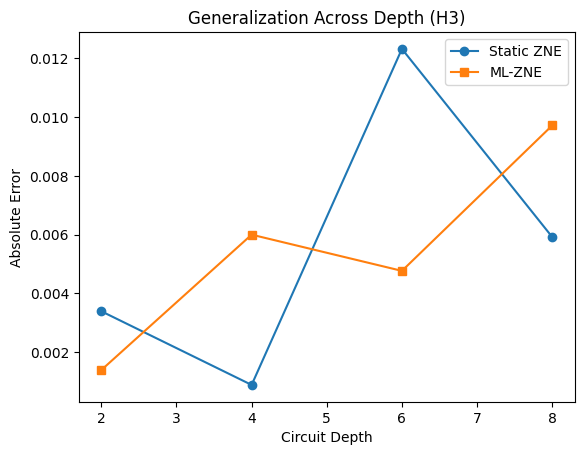

In [ ]:
plt.plot(depths, errors_static, "o-", label="Static ZNE")
plt.plot(depths, errors_ml, "s-", label="ML-ZNE")
plt.xlabel("Circuit Depth")
plt.ylabel("Absolute Error")
plt.title("Generalization Across Depth (H3)")
plt.legend()
plt.show()
